## Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from pprint import pprint
tf.random.set_seed(1234)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam,Nadam
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/final_test.csv')

First, we will drop the index column "Unnamed: 0", "Q_num" and "URL".

Second, we will encode the "Rank" column.


In [ ]:
df.shape

(860, 8)

In [ ]:
df.head()

,Unnamed: 0,Q_num,Question,Answer,Focus,Qtype,Rank,URL
0,0,1.0,What causes Noonan syndrome ?,Noonan syndrome is linked to defects in severa...,Noonan syndrome,causes,2-Related,https://www.nlm.nih.gov/medlineplus/ency/artic...
1,1,1.0,What are the complications of Noonan syndrome ?,- Buildup of fluid in tissues of body (lymphed...,Noonan syndrome,complications,2-Related,https://www.nlm.nih.gov/medlineplus/ency/artic...
2,2,1.0,How to prevent Noonan syndrome ?,Couples with a family history of Noonan syndro...,Noonan syndrome,prevention,2-Related,https://www.nlm.nih.gov/medlineplus/ency/artic...
3,3,1.0,What is (are) Noonan syndrome ?,Noonan syndrome is a disease that can be passe...,Noonan syndrome,information,3-Incomplete,https://www.nlm.nih.gov/medlineplus/ency/artic...
4,4,1.0,What causes Noonan syndrome ?,Noonan syndrome is linked to defects in severa...,Noonan syndrome,causes,3-Incomplete,https://www.nlm.nih.gov/medlineplus/ency/artic...


In [ ]:
df.nunique()

Unnamed: 0    860
Q_num          98
Question      612
Answer        663
Focus         311
Qtype          34
Rank            4
URL           326
dtype: int64

In [ ]:
df['Qtype'].value_counts()

information                                341
causes                                      63
usage                                       45
other information                           43
brand names                                 37
side effects                                30
forget a dose                               29
treatment                                   26
indication                                  26
prevention                                  25
symptoms                                    23
emergency or overdose                       22
how can i learn more                        19
research                                    15
when to contact a medical professional      14
considerations                              14
support groups                              13
precautions                                 11
storage and disposal                        10
exams and tests                              9
outlook                                      7
brand names o

In [ ]:
#Dropping columns
df.drop(columns=["Unnamed: 0", "Q_num", "URL","Focus"], inplace=True)

#Encoding "Rank" column
for i in range (len(df)):
  df['Rank'].values[i]=df['Rank'].values[i][0]

df['Rank']=df['Rank'].astype(int)
df['Rank']=df['Rank']-1

In [ ]:
df_info=df[df['Qtype']=='information']
df_causes=df[df['Qtype']=='causes']
df_usage=df[df['Qtype']=='usage']
df_other=df[df['Qtype']=='other information']
df_brands=df[df['Qtype']=='brand names']

## First Trial


In [ ]:
df_info.drop(columns=["Qtype"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_info.shape

(341, 3)

In [ ]:
train, test = train_test_split(
    df_info, test_size=0.2, random_state=42)

In [ ]:
xtr=train.loc[:, train.columns != 'Rank']
ytr=train.loc[:, train.columns == 'Rank']

xts=df_info.loc[:, test.columns != 'Rank']
yts=df_info.loc[:, test.columns == 'Rank']

In [ ]:
# preprocess text data

vocab_sizeQ = 100000
vocab_sizeA=150000
max_lenQ = 100
max_lenA = 150


# build vocabulary from training set
tokenizerQ = Tokenizer(num_words=vocab_sizeQ)
tokenizerQ.fit_on_texts(xtr['Question'])

tokenizerA = Tokenizer(num_words=vocab_sizeA)
tokenizerA.fit_on_texts(xtr['Answer'])


def Q_preprocess(list_of_text):
    return pad_sequences(
        tokenizerQ.texts_to_sequences(list_of_text),
        maxlen=max_lenQ,
        padding='post',
    )

def A_preprocess(list_of_text):
    return pad_sequences(
        tokenizerA.texts_to_sequences(list_of_text),
        maxlen=max_lenA,
        padding='post',
    )   

# padding is done inside: 
pre_Q = Q_preprocess(xtr['Question'])
pre_A = A_preprocess(xtr['Answer'])
print(pre_Q.shape)
print(pre_A.shape)

(272, 100)
(272, 150)


In [ ]:
#Preprocess test data
pre_Qt = Q_preprocess(xts['Question'])
pre_At = A_preprocess(xts['Answer'])

In [ ]:
in_Q = keras.Input(batch_shape=(None, max_lenQ))
in_A = keras.Input(batch_shape=(None, max_lenA))
# Bidirectional LSTMs are an extension of traditional LSTMs that can improve model
# performance on sequence classification problems.
embedded1 = keras.layers.Embedding(tokenizerQ.num_words, 100)(in_Q)
bidirectional = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded1)
bidirectional1 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False)) (bidirectional)
#bidirectional2 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded1)#(bidirectional1)
fc1 = Dense(100, activation='relu')(bidirectional1)
print(fc1)
embedded2 = keras.layers.Embedding(tokenizerA.num_words, 100)(in_A)
merged = keras.layers.Concatenate(axis=1)([embedded1, embedded2])
bidirectional3 = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded2)
bidirectional4 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False))(bidirectional3)
#bidirectional5 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded2)#(bidirectional4)
fc2 = Dense(100, activation='relu')(bidirectional4)


fused = keras.layers.Concatenate(axis=1)([fc1, fc2])

rank = Dense(4, activation='softmax', name='type')(fused)

model = keras.Model(
    inputs={
        'Question':in_Q,
        'Answer':in_A
    },
    outputs=rank
)

model.compile(
    optimizer=Nadam(),
    loss='sparse_categorical_crossentropy', 
    metrics='SparseCategoricalAccuracy' 

)

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense/Relu:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     10000000    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 150, 100)  

In [ ]:
history = model.fit(
    x={
        'Question': pre_Q,
        'Answer': pre_A
    },
    y=ytr,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True )
    ],
    verbose=1
)

Epoch 1/20
7/7 [==============================] - 17s 723ms/step - loss: 1.2901 - sparse_categorical_accuracy: 0.5945 - val_loss: 1.0082 - val_sparse_categorical_accuracy: 0.6545
Epoch 2/20
7/7 [==============================] - 2s 259ms/step - loss: 0.9820 - sparse_categorical_accuracy: 0.6452 - val_loss: 0.9572 - val_sparse_categorical_accuracy: 0.6545
Epoch 3/20
7/7 [==============================] - 2s 244ms/step - loss: 0.8602 - sparse_categorical_accuracy: 0.6452 - val_loss: 0.9916 - val_sparse_categorical_accuracy: 0.6727
Epoch 4/20
7/7 [==============================] - 2s 246ms/step - loss: 0.7413 - sparse_categorical_accuracy: 0.7005 - val_loss: 1.1004 - val_sparse_categorical_accuracy: 0.6909
Epoch 5/20
7/7 [==============================] - 2s 251ms/step - loss: 0.5601 - sparse_categorical_accuracy: 0.7880 - val_loss: 1.1411 - val_sparse_categorical_accuracy: 0.6364
Epoch 6/20
7/7 [==============================] - 2s 251ms/step - loss: 0.4468 - sparse_categorical_accuracy:

In [ ]:
y_predict = model.predict(
    {
        'Question': pre_Qt,
        'Answer': pre_At
    }
)

In [ ]:
info_scores=[]
for i in range(len(y_predict)):
  info_scores.append(y_predict[i][df_info.iloc[i,2]])

In [ ]:
len(info_scores)

341

## Second Trial

In [ ]:
df_causes.drop(columns=["Qtype"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_causes.shape

(63, 3)

In [ ]:
train, test = train_test_split(
    df_causes, test_size=0.2, random_state=42)

In [ ]:
xtr=train.loc[:, train.columns != 'Rank']
ytr=train.loc[:, train.columns == 'Rank']

xts=df_causes.loc[:, test.columns != 'Rank']
yts=df_causes.loc[:, test.columns == 'Rank']

In [ ]:
# preprocess text data

vocab_sizeQ = 100000
vocab_sizeA=150000
max_lenQ = 100
max_lenA = 150


# build vocabulary from training set
tokenizerQ = Tokenizer(num_words=vocab_sizeQ)
tokenizerQ.fit_on_texts(xtr['Question'])

tokenizerA = Tokenizer(num_words=vocab_sizeA)
tokenizerA.fit_on_texts(xtr['Answer'])


def Q_preprocess(list_of_text):
    return pad_sequences(
        tokenizerQ.texts_to_sequences(list_of_text),
        maxlen=max_lenQ,
        padding='post',
    )

def A_preprocess(list_of_text):
    return pad_sequences(
        tokenizerA.texts_to_sequences(list_of_text),
        maxlen=max_lenA,
        padding='post',
    )   

# padding is done inside: 
pre_Q = Q_preprocess(xtr['Question'])
pre_A = A_preprocess(xtr['Answer'])
print(pre_Q.shape)
print(pre_A.shape)

(50, 100)
(50, 150)


In [ ]:
#Preprocess test data
pre_Qt = Q_preprocess(xts['Question'])
pre_At = A_preprocess(xts['Answer'])

In [ ]:
in_Q = keras.Input(batch_shape=(None, max_lenQ))
in_A = keras.Input(batch_shape=(None, max_lenA))
# Bidirectional LSTMs are an extension of traditional LSTMs that can improve model
# performance on sequence classification problems.
embedded1 = keras.layers.Embedding(tokenizerQ.num_words, 100)(in_Q)
bidirectional = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded1)
bidirectional1 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False)) (bidirectional)
#bidirectional2 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded1)#(bidirectional1)
fc1 = Dense(100, activation='relu')(bidirectional1)
print(fc1)
embedded2 = keras.layers.Embedding(tokenizerA.num_words, 100)(in_A)
merged = keras.layers.Concatenate(axis=1)([embedded1, embedded2])
bidirectional3 = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded2)
bidirectional4 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False))(bidirectional3)
#bidirectional5 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded2)#(bidirectional4)
fc2 = Dense(100, activation='relu')(bidirectional4)


fused = keras.layers.Concatenate(axis=1)([fc1, fc2])

rank = Dense(4, activation='softmax', name='type')(fused)

model = keras.Model(
    inputs={
        'Question':in_Q,
        'Answer':in_A
    },
    outputs=rank
)

model.compile(
    optimizer=Nadam(),
    loss='sparse_categorical_crossentropy', 
    metrics='SparseCategoricalAccuracy' 

)

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_6/Relu:0', description="created by layer 'dense_6'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 100, 100)     10000000    ['input_7[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, 150, 

In [ ]:
history = model.fit(
    x={
        'Question': pre_Q,
        'Answer': pre_A
    },
    y=ytr,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True )
    ],
    verbose=1
)

Epoch 1/20
2/2 [==============================] - 19s 4s/step - loss: 1.3806 - sparse_categorical_accuracy: 0.3500 - val_loss: 1.3927 - val_sparse_categorical_accuracy: 0.3000
Epoch 2/20
2/2 [==============================] - 1s 302ms/step - loss: 1.3457 - sparse_categorical_accuracy: 0.5250 - val_loss: 1.3963 - val_sparse_categorical_accuracy: 0.3000
Epoch 3/20
2/2 [==============================] - 1s 307ms/step - loss: 1.3002 - sparse_categorical_accuracy: 0.5250 - val_loss: 1.4483 - val_sparse_categorical_accuracy: 0.3000
Epoch 4/20
2/2 [==============================] - 1s 293ms/step - loss: 1.2168 - sparse_categorical_accuracy: 0.5250 - val_loss: 1.7069 - val_sparse_categorical_accuracy: 0.3000
Epoch 5/20
2/2 [==============================] - 1s 288ms/step - loss: 1.1872 - sparse_categorical_accuracy: 0.5250 - val_loss: 1.5172 - val_sparse_categorical_accuracy: 0.3000
Epoch 6/20
2/2 [==============================] - 1s 318ms/step - loss: 1.1500 - sparse_categorical_accuracy: 0.

In [ ]:
y_predict = model.predict(
    {
        'Question': pre_Qt,
        'Answer': pre_At
    }
)

In [ ]:
# model.evaluate(
#         x={
#         'Question': pre_Qt,
#         'Answer': pre_At
#         }, 
#         y=yts)

78/78 [==============================] - 7s 88ms/step - loss: 0.8246 - sparse_categorical_accuracy: 0.7620


[0.8245623707771301, 0.7620007991790771]

In [ ]:
cause_scores=[]
for i in range(len(y_predict)):
  cause_scores.append(y_predict[i][df_causes.iloc[i,2]])

In [ ]:
len(cause_scores)

63

## Third Trial

In [ ]:
df_usage.drop(columns=["Qtype"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_usage.shape

(45, 3)

In [ ]:
train, test = train_test_split(
    df_usage, test_size=0.2, random_state=42)

In [ ]:
xtr=train.loc[:, train.columns != 'Rank']
ytr=train.loc[:, train.columns == 'Rank']

xts=df_usage.loc[:, test.columns != 'Rank']
yts=df_usage.loc[:, test.columns == 'Rank']

In [ ]:
# preprocess text data

vocab_sizeQ = 100000
vocab_sizeA=150000
max_lenQ = 100
max_lenA = 150


# build vocabulary from training set
tokenizerQ = Tokenizer(num_words=vocab_sizeQ)
tokenizerQ.fit_on_texts(xtr['Question'])

tokenizerA = Tokenizer(num_words=vocab_sizeA)
tokenizerA.fit_on_texts(xtr['Answer'])


def Q_preprocess(list_of_text):
    return pad_sequences(
        tokenizerQ.texts_to_sequences(list_of_text),
        maxlen=max_lenQ,
        padding='post',
    )

def A_preprocess(list_of_text):
    return pad_sequences(
        tokenizerA.texts_to_sequences(list_of_text),
        maxlen=max_lenA,
        padding='post',
    )   

# padding is done inside: 
pre_Q = Q_preprocess(xtr['Question'])
pre_A = A_preprocess(xtr['Answer'])
print(pre_Q.shape)
print(pre_A.shape)

(36, 100)
(36, 150)


In [ ]:
#Preprocess test data
pre_Qt = Q_preprocess(xts['Question'])
pre_At = A_preprocess(xts['Answer'])

In [ ]:
in_Q = keras.Input(batch_shape=(None, max_lenQ))
in_A = keras.Input(batch_shape=(None, max_lenA))
# Bidirectional LSTMs are an extension of traditional LSTMs that can improve model
# performance on sequence classification problems.
embedded1 = keras.layers.Embedding(tokenizerQ.num_words, 100)(in_Q)
bidirectional = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded1)
bidirectional1 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False)) (bidirectional)
#bidirectional2 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded1)#(bidirectional1)
fc1 = Dense(100, activation='relu')(bidirectional1)
print(fc1)
embedded2 = keras.layers.Embedding(tokenizerA.num_words, 100)(in_A)
merged = keras.layers.Concatenate(axis=1)([embedded1, embedded2])
bidirectional3 = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded2)
bidirectional4 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False))(bidirectional3)
#bidirectional5 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded2)#(bidirectional4)
fc2 = Dense(100, activation='relu')(bidirectional4)


fused = keras.layers.Concatenate(axis=1)([fc1, fc2])

rank = Dense(4, activation='softmax', name='type')(fused)

model = keras.Model(
    inputs={
        'Question':in_Q,
        'Answer':in_A
    },
    outputs=rank
)

model.compile(
    optimizer=Nadam(),
    loss='sparse_categorical_crossentropy', 
    metrics='SparseCategoricalAccuracy' 

)

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_10/Relu:0', description="created by layer 'dense_10'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 100, 100)     10000000    ['input_11[0][0]']               
                                                                                                  
 embedding_11 (Embedding)       (None, 150

In [ ]:
history = model.fit(
    x={
        'Question': pre_Q,
        'Answer': pre_A
    },
    y=ytr,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True )
    ],
    verbose=1
)

Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 1.3894 - sparse_categorical_accuracy: 0.0357 - val_loss: 1.3754 - val_sparse_categorical_accuracy: 0.1250
Epoch 2/20
1/1 [==============================] - 0s 451ms/step - loss: 1.3594 - sparse_categorical_accuracy: 0.5714 - val_loss: 1.3660 - val_sparse_categorical_accuracy: 0.2500
Epoch 3/20
1/1 [==============================] - 0s 438ms/step - loss: 1.3316 - sparse_categorical_accuracy: 0.5357 - val_loss: 1.3536 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/20
1/1 [==============================] - 0s 423ms/step - loss: 1.2964 - sparse_categorical_accuracy: 0.5357 - val_loss: 1.3368 - val_sparse_categorical_accuracy: 0.2500
Epoch 5/20
1/1 [==============================] - 0s 450ms/step - loss: 1.2444 - sparse_categorical_accuracy: 0.5357 - val_loss: 1.3175 - val_sparse_categorical_accuracy: 0.2500
Epoch 6/20
1/1 [==============================] - 0s 453ms/step - loss: 1.1663 - sparse_categorical_accuracy: 0

In [ ]:
y_predict = model.predict(
    {
        'Question': pre_Qt,
        'Answer': pre_At
    }
)

In [ ]:
y_predict.shape

(45, 4)

In [ ]:
usage_scores=[]
for i in range(len(y_predict)):
  usage_scores.append(y_predict[i][df_usage.iloc[i,2]])

In [ ]:
len(usage_scores)

45

## Fourth Trial

In [ ]:
df_other.drop(columns=["Qtype"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_other.shape

(43, 3)

In [ ]:
train, test = train_test_split(
    df_other, test_size=0.2, random_state=42)

In [ ]:
xtr=train.loc[:, train.columns != 'Rank']
ytr=train.loc[:, train.columns == 'Rank']

xts=df_other.loc[:, test.columns != 'Rank']
yts=df_other.loc[:, test.columns == 'Rank']

In [ ]:
# preprocess text data

vocab_sizeQ = 100000
vocab_sizeA=150000
max_lenQ = 100
max_lenA = 150


# build vocabulary from training set
tokenizerQ = Tokenizer(num_words=vocab_sizeQ)
tokenizerQ.fit_on_texts(xtr['Question'])

tokenizerA = Tokenizer(num_words=vocab_sizeA)
tokenizerA.fit_on_texts(xtr['Answer'])


def Q_preprocess(list_of_text):
    return pad_sequences(
        tokenizerQ.texts_to_sequences(list_of_text),
        maxlen=max_lenQ,
        padding='post',
    )

def A_preprocess(list_of_text):
    return pad_sequences(
        tokenizerA.texts_to_sequences(list_of_text),
        maxlen=max_lenA,
        padding='post',
    )   

# padding is done inside: 
pre_Q = Q_preprocess(xtr['Question'])
pre_A = A_preprocess(xtr['Answer'])
print(pre_Q.shape)
print(pre_A.shape)

(34, 100)
(34, 150)


In [ ]:
#Preprocess test data
pre_Qt = Q_preprocess(xts['Question'])
pre_At = A_preprocess(xts['Answer'])

In [ ]:
in_Q = keras.Input(batch_shape=(None, max_lenQ))
in_A = keras.Input(batch_shape=(None, max_lenA))
# Bidirectional LSTMs are an extension of traditional LSTMs that can improve model
# performance on sequence classification problems.
embedded1 = keras.layers.Embedding(tokenizerQ.num_words, 100)(in_Q)
bidirectional = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded1)
bidirectional1 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False)) (bidirectional)
#bidirectional2 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded1)#(bidirectional1)
fc1 = Dense(100, activation='relu')(bidirectional1)
print(fc1)
embedded2 = keras.layers.Embedding(tokenizerA.num_words, 100)(in_A)
merged = keras.layers.Concatenate(axis=1)([embedded1, embedded2])
bidirectional3 = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded2)
bidirectional4 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False))(bidirectional3)
#bidirectional5 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded2)#(bidirectional4)
fc2 = Dense(100, activation='relu')(bidirectional4)


fused = keras.layers.Concatenate(axis=1)([fc1, fc2])

rank = Dense(4, activation='softmax', name='type')(fused)

model = keras.Model(
    inputs={
        'Question':in_Q,
        'Answer':in_A
    },
    outputs=rank
)

model.compile(
    optimizer=Nadam(),
    loss='sparse_categorical_crossentropy', 
    metrics='SparseCategoricalAccuracy' 

)

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_12/Relu:0', description="created by layer 'dense_12'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 100, 100)     10000000    ['input_13[0][0]']               
                                                                                                  
 embedding_13 (Embedding)       (None, 150

In [ ]:
history = model.fit(
    x={
        'Question': pre_Q,
        'Answer': pre_A
    },
    y=ytr,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True )
    ],
    verbose=1
)

Epoch 1/20
1/1 [==============================] - 18s 18s/step - loss: 1.3880 - sparse_categorical_accuracy: 0.2222 - val_loss: 1.3492 - val_sparse_categorical_accuracy: 0.7143
Epoch 2/20
1/1 [==============================] - 0s 406ms/step - loss: 1.3342 - sparse_categorical_accuracy: 0.8519 - val_loss: 1.3131 - val_sparse_categorical_accuracy: 0.7143
Epoch 3/20
1/1 [==============================] - 0s 389ms/step - loss: 1.2853 - sparse_categorical_accuracy: 0.8519 - val_loss: 1.2652 - val_sparse_categorical_accuracy: 0.7143
Epoch 4/20
1/1 [==============================] - 0s 380ms/step - loss: 1.2206 - sparse_categorical_accuracy: 0.8519 - val_loss: 1.1935 - val_sparse_categorical_accuracy: 0.7143
Epoch 5/20
1/1 [==============================] - 0s 387ms/step - loss: 1.1209 - sparse_categorical_accuracy: 0.8519 - val_loss: 1.0887 - val_sparse_categorical_accuracy: 0.7143
Epoch 6/20
1/1 [==============================] - 0s 378ms/step - loss: 0.9677 - sparse_categorical_accuracy: 0

In [ ]:
y_predict = model.predict(
    {
        'Question': pre_Qt,
        'Answer': pre_At
    }
)

In [ ]:
y_predict.shape

(43, 4)

In [ ]:
other_scores=[]
for i in range(len(y_predict)):
  other_scores.append(y_predict[i][df_other.iloc[i,2]])

In [ ]:
len(usage_scores)

45

## Fifth Trial

In [ ]:
df_brands.drop(columns=["Qtype"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_brands.shape

(37, 3)

In [ ]:
train, test = train_test_split(
    df_brands, test_size=0.2, random_state=42)

In [ ]:
xtr=train.loc[:, train.columns != 'Rank']
ytr=train.loc[:, train.columns == 'Rank']

xts=df_brands.loc[:, test.columns != 'Rank']
yts=df_brands.loc[:, test.columns == 'Rank']

In [ ]:
# preprocess text data

vocab_sizeQ = 100000
vocab_sizeA=150000
max_lenQ = 100
max_lenA = 150


# build vocabulary from training set
tokenizerQ = Tokenizer(num_words=vocab_sizeQ)
tokenizerQ.fit_on_texts(xtr['Question'])

tokenizerA = Tokenizer(num_words=vocab_sizeA)
tokenizerA.fit_on_texts(xtr['Answer'])


def Q_preprocess(list_of_text):
    return pad_sequences(
        tokenizerQ.texts_to_sequences(list_of_text),
        maxlen=max_lenQ,
        padding='post',
    )

def A_preprocess(list_of_text):
    return pad_sequences(
        tokenizerA.texts_to_sequences(list_of_text),
        maxlen=max_lenA,
        padding='post',
    )   

# padding is done inside: 
pre_Q = Q_preprocess(xtr['Question'])
pre_A = A_preprocess(xtr['Answer'])
print(pre_Q.shape)
print(pre_A.shape)

(29, 100)
(29, 150)


In [ ]:
#Preprocess test data
pre_Qt = Q_preprocess(xts['Question'])
pre_At = A_preprocess(xts['Answer'])

In [ ]:
in_Q = keras.Input(batch_shape=(None, max_lenQ))
in_A = keras.Input(batch_shape=(None, max_lenA))
# Bidirectional LSTMs are an extension of traditional LSTMs that can improve model
# performance on sequence classification problems.
embedded1 = keras.layers.Embedding(tokenizerQ.num_words, 100)(in_Q)
bidirectional = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded1)
bidirectional1 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False)) (bidirectional)
#bidirectional2 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded1)#(bidirectional1)
fc1 = Dense(100, activation='relu')(bidirectional1)
print(fc1)
embedded2 = keras.layers.Embedding(tokenizerA.num_words, 100)(in_A)
merged = keras.layers.Concatenate(axis=1)([embedded1, embedded2])
bidirectional3 = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded2)
bidirectional4 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False))(bidirectional3)
#bidirectional5 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded2)#(bidirectional4)
fc2 = Dense(100, activation='relu')(bidirectional4)


fused = keras.layers.Concatenate(axis=1)([fc1, fc2])

rank = Dense(4, activation='softmax', name='type')(fused)

model = keras.Model(
    inputs={
        'Question':in_Q,
        'Answer':in_A
    },
    outputs=rank
)

model.compile(
    optimizer=Nadam(),
    loss='sparse_categorical_crossentropy', 
    metrics='SparseCategoricalAccuracy' 

)

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_14/Relu:0', description="created by layer 'dense_14'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 100, 100)     10000000    ['input_15[0][0]']               
                                                                                                  
 embedding_15 (Embedding)       (None, 150

In [ ]:
history = model.fit(
    x={
        'Question': pre_Q,
        'Answer': pre_A
    },
    y=ytr,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True )
    ],
    verbose=1
)

Epoch 1/20
1/1 [==============================] - 16s 16s/step - loss: 1.3702 - sparse_categorical_accuracy: 0.8261 - val_loss: 1.3157 - val_sparse_categorical_accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 0s 336ms/step - loss: 1.3187 - sparse_categorical_accuracy: 0.8261 - val_loss: 1.2618 - val_sparse_categorical_accuracy: 0.8333
Epoch 3/20
1/1 [==============================] - 0s 341ms/step - loss: 1.2657 - sparse_categorical_accuracy: 0.8261 - val_loss: 1.1904 - val_sparse_categorical_accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 0s 353ms/step - loss: 1.1953 - sparse_categorical_accuracy: 0.8261 - val_loss: 1.0885 - val_sparse_categorical_accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 0s 337ms/step - loss: 1.0956 - sparse_categorical_accuracy: 0.8261 - val_loss: 0.9337 - val_sparse_categorical_accuracy: 0.8333
Epoch 6/20
1/1 [==============================] - 0s 343ms/step - loss: 0.9436 - sparse_categorical_accuracy: 0

In [ ]:
y_predict = model.predict(
    {
        'Question': pre_Qt,
        'Answer': pre_At
    }
)

In [ ]:
y_predict.shape

(37, 4)

In [ ]:
brand_scores=[]
for i in range(len(y_predict)):
  brand_scores.append(y_predict[i][df_brands.iloc[i,2]])

In [ ]:
len(brand_scores)

37

## Sixth Trial

In [ ]:
df_non_info=df[df['Qtype']!='information']

In [ ]:
df_non_info.shape

(519, 4)

In [ ]:
df_non_info.drop(columns=["Qtype"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_non_info.shape

(519, 3)

In [ ]:
train, test = train_test_split(
    df_non_info, test_size=0.2, random_state=42)

In [ ]:
xtr=train.loc[:, train.columns != 'Rank']
ytr=train.loc[:, train.columns == 'Rank']

xts=df_non_info.loc[:, test.columns != 'Rank']
yts=df_non_info.loc[:, test.columns == 'Rank']

In [ ]:
# preprocess text data

vocab_sizeQ = 100000
vocab_sizeA=150000
max_lenQ = 100
max_lenA = 150


# build vocabulary from training set
tokenizerQ = Tokenizer(num_words=vocab_sizeQ)
tokenizerQ.fit_on_texts(xtr['Question'])

tokenizerA = Tokenizer(num_words=vocab_sizeA)
tokenizerA.fit_on_texts(xtr['Answer'])


def Q_preprocess(list_of_text):
    return pad_sequences(
        tokenizerQ.texts_to_sequences(list_of_text),
        maxlen=max_lenQ,
        padding='post',
    )

def A_preprocess(list_of_text):
    return pad_sequences(
        tokenizerA.texts_to_sequences(list_of_text),
        maxlen=max_lenA,
        padding='post',
    )   

# padding is done inside: 
pre_Q = Q_preprocess(xtr['Question'])
pre_A = A_preprocess(xtr['Answer'])
print(pre_Q.shape)
print(pre_A.shape)

(415, 100)
(415, 150)


In [ ]:
#Preprocess test data
pre_Qt = Q_preprocess(xts['Question'])
pre_At = A_preprocess(xts['Answer'])

In [ ]:
in_Q = keras.Input(batch_shape=(None, max_lenQ))
in_A = keras.Input(batch_shape=(None, max_lenA))
# Bidirectional LSTMs are an extension of traditional LSTMs that can improve model
# performance on sequence classification problems.
embedded1 = keras.layers.Embedding(tokenizerQ.num_words, 100)(in_Q)
bidirectional = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded1)
bidirectional1 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False)) (bidirectional)
#bidirectional2 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded1)#(bidirectional1)
fc1 = Dense(100, activation='relu')(bidirectional1)
print(fc1)
embedded2 = keras.layers.Embedding(tokenizerA.num_words, 100)(in_A)
merged = keras.layers.Concatenate(axis=1)([embedded1, embedded2])
bidirectional3 = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embedded2)
bidirectional4 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False))(bidirectional3)
#bidirectional5 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=False))(embedded2)#(bidirectional4)
fc2 = Dense(100, activation='relu')(bidirectional4)


fused = keras.layers.Concatenate(axis=1)([fc1, fc2])

rank = Dense(4, activation='softmax', name='type')(fused)

model = keras.Model(
    inputs={
        'Question':in_Q,
        'Answer':in_A
    },
    outputs=rank
)

model.compile(
    optimizer=Nadam(),
    loss='sparse_categorical_crossentropy', 
    metrics='SparseCategoricalAccuracy' 

)

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_2/Relu:0', description="created by layer 'dense_2'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 100)     10000000    ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 150, 

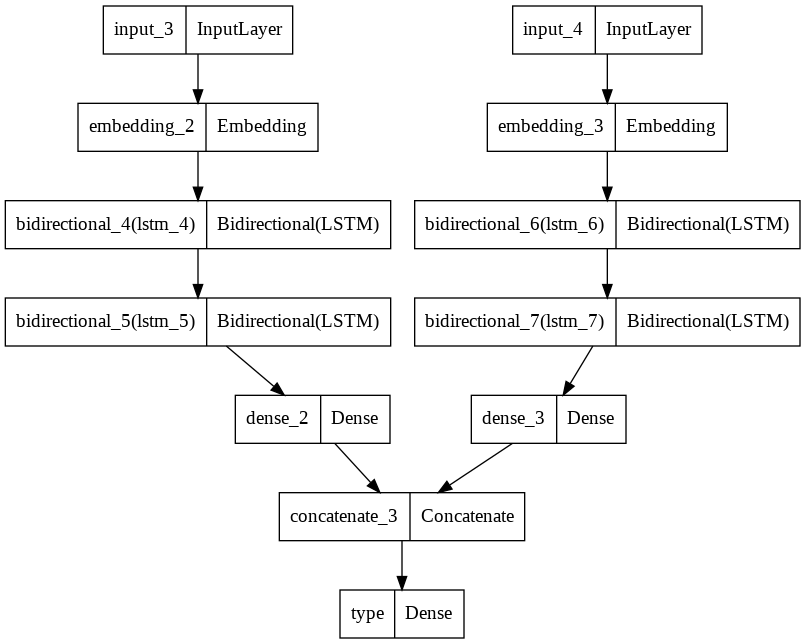

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
history = model.fit(
    x={
        'Question': pre_Q,
        'Answer': pre_A
    },
    y=ytr,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True )
    ],
    verbose=1
)

Epoch 1/20
11/11 [==============================] - 18s 525ms/step - loss: 1.2762 - sparse_categorical_accuracy: 0.4639 - val_loss: 1.2415 - val_sparse_categorical_accuracy: 0.4819
Epoch 2/20
11/11 [==============================] - 3s 253ms/step - loss: 1.1061 - sparse_categorical_accuracy: 0.5060 - val_loss: 1.2501 - val_sparse_categorical_accuracy: 0.4819
Epoch 3/20
11/11 [==============================] - 3s 268ms/step - loss: 1.0269 - sparse_categorical_accuracy: 0.5633 - val_loss: 1.1724 - val_sparse_categorical_accuracy: 0.5422
Epoch 4/20
11/11 [==============================] - 3s 274ms/step - loss: 0.8212 - sparse_categorical_accuracy: 0.7139 - val_loss: 1.0861 - val_sparse_categorical_accuracy: 0.5904
Epoch 5/20
11/11 [==============================] - 3s 269ms/step - loss: 0.6168 - sparse_categorical_accuracy: 0.8102 - val_loss: 1.1595 - val_sparse_categorical_accuracy: 0.5422
Epoch 6/20
11/11 [==============================] - 3s 273ms/step - loss: 0.4929 - sparse_categoric

In [ ]:
y_predict = model.predict(
    {
        'Question': pre_Qt,
        'Answer': pre_At
    }
)

In [ ]:
y_predict.shape

(519, 4)

In [ ]:
non_info_scores=[]
for i in range(len(y_predict)):
  non_info_scores.append(y_predict[i][df_non_info.iloc[i,2]])

In [ ]:
len(non_info_scores)

519

## 1st Hypothesis Test: Does the model perform better on different question types? 

-For this question, we used the top 5 most frequent question types since other types contained too few questions.

-Since the 5 classes would not be of the same length, we decided to use the "Kruskal-Wallis H-test"

-For the null hypothesis, we assume that the question type has no effect on the model performance.

-For the alternative hypothesis, we assume that the question type has an effect on the model performance.

In [ ]:
!pip install scipy=='1.6.0'
from scipy import stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
stats.kruskal(info_scores,usage_scores,cause_scores,other_scores,brand_scores)

KruskalResult(statistic=120.58055309842428, pvalue=4.014737579625164e-25)

Since the p-value is very small (less than 0.05), this means that we can reject the null hypothesis and conclude that question type **does** have an effect on the model performance

## 2st Hypothesis Test: Does the model perform better on question types with bigger entries? 

-Since the "information" question type has 341 entries (wjich is almost 40% of the data), we decided to test whether the model performs better on "information" questions as compared to all other questions, where there is no other dominant question type in the dataset.

-We decided to use 2 classes of the same size, one for all the "information" questions and another for the remaining types and use the T-test 

-For the null hypothesis, we assume that the number of entries in question type has no effect on the model performance

-For the alternative hypothesis, we assume that the number of entries in question type has an effect on the model performance

In [ ]:
scores2=non_info_scores[:341]

In [ ]:
stats.ttest_ind(info_scores, scores2,alternative='less')

Ttest_indResult(statistic=-3.6876589823956976, pvalue=0.00012219282050438668)

As we can see from the p-value, the null hypothesis can be rejected implying that the number of questions in each question type does have an effect on the model performance. Moreover, since the alternative parameter was "less", this means that question with not no many question types achieved better scores that the dominant question type "information".